Fold 1:
  MSE = 110.22
  R²  = -2.8232
------------------------------
Fold 2:
  MSE = 120.14
  R²  = -0.0023
------------------------------
Fold 3:
  MSE = 2800.42
  R²  = -4.1134
------------------------------
Fold 4:
  MSE = 51.53
  R²  = 0.8121
------------------------------
Fold 5:
  MSE = 940.02
  R²  = -0.4878
------------------------------

Average MSE across folds: 804.47
Average R² across folds: -1.3229


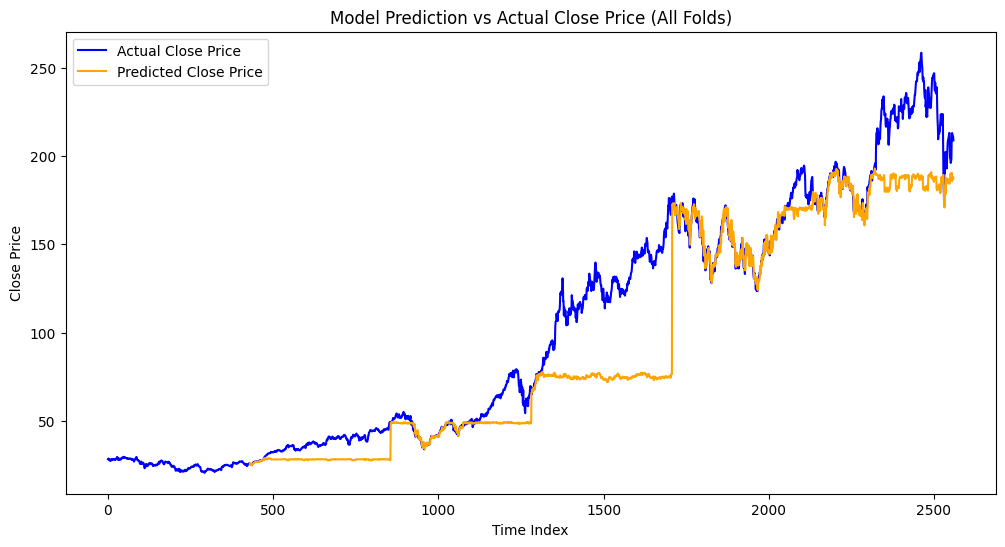

In [4]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt


# Load data
data = pd.read_csv('../data/processed_data.csv')

# Convert columns to numeric (replace invalid parsing with NaN)
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop NaN from conversion or shifting
data.dropna(inplace=True)

# Create target: next-day close price
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)  # Drop the final NaN row

# Define features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []
r2_scores = []

# Create arrays to store full predictions and actuals
all_preds = np.zeros(len(y))
all_preds[:] = np.nan  # Fill with NaNs so we don't overwrite training parts
all_actuals = y.copy()

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    all_preds[test_index] = predictions  # Only fill in test set predictions

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold+1}:")
    print(f"  MSE = {mse:.2f}")
    print(f"  R²  = {r2:.4f}")
    print("-" * 30)

print(f"\nAverage MSE across folds: {np.mean(mse_scores):.2f}")
print(f"Average R² across folds: {np.mean(r2_scores):.4f}")

# ✅ Plot all predictions vs actuals across full timeline
plt.figure(figsize=(12,6))
plt.plot(all_actuals.values, label='Actual Close Price', color='blue')
plt.plot(all_preds, label='Predicted Close Price', color='orange')
plt.title('Model Prediction vs Actual Close Price (All Folds)')
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()



 